# <u>Demand Forecasting - Statistical Methods</u>

## Problem statement:

Use statistical methods to forecast demand. The dataset used consists of monthly sales of new cars in Norway from Jan 2007 to Jan 2017. In this analysis we will focus only on one product. The analysis for multiple products will be treated separately.

## Overview:

1. Data Preparation and KPIs
2. Moving Average Forecast
3. Simple Exponential Smoothing
4. Double Exponential Smoothing
5. Double Exponential Smoothing with Damped Trend
6. Triple Exponential Smoothing (Multiplicative) with Damped Trend
7. Triple Exponential Smoothing (Additive) with Damped Trend
8. Optimizing the parameters
9. Final Results

## 1. Data preparation and KPIs

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv(
    '/content/drive/MyDrive/Demand_Forecasting_Project/norway_car_sales/norway_new_car_sales_by_make.csv'
)
data.head()

,Year,Month,Make,Quantity,Pct
0,2007,1,Toyota,2884,22.7
1,2007,1,Volkswagen,2521,19.9
2,2007,1,Peugeot,1029,8.1
3,2007,1,Ford,870,6.9
4,2007,1,Volvo,693,5.5


In [ ]:
# Checking for null values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4377 entries, 0 to 4376
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      4377 non-null   int64  
 1   Month     4377 non-null   int64  
 2   Make      4367 non-null   object 
 3   Quantity  4377 non-null   int64  
 4   Pct       4377 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 171.1+ KB


The 'Make' column has 10 null values, the null values will be dropped. The data will also have to be transformed such that it can be used for time-series forecasting. For that, we will first add a new column that combines the year and month together in 'YYYY-MM' format.

In [ ]:
# Initial processing

data.dropna(inplace=True)
data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)

df = pd.pivot_table(
    data=data,
    index='Make',
    columns='Period',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

df.head()

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


As we want to focus only one product type, in this case it is the car make, we will choose 'Audi' for our analysis.

In [ ]:
df_audi = df[df.index == 'Audi']
df_audi.head()

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565


In [ ]:
# Function to plot demand v time period

def plot_data(df, results_df=None, title="Historic Demand"):
    plt.figure(figsize=(15, 6))
    if results_df is not None:
        plt.plot(df.columns.values.ravel()[-(results_df.shape[0]):], results_df['Demand'].values.ravel(), '-o')
        plt.plot(df.columns.values.ravel()[-(results_df.shape[0]):], results_df['Forecast'].values.ravel(), '-o')
        plt.xticks(df.columns.values.ravel()[-(results_df.shape[0])::2], rotation=90)
    else:
        plt.plot(df.columns.values.ravel(), df.values.ravel(), '-o')
        plt.xticks(df.columns.values.ravel()[::2], rotation=90)
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Demand Quantity')
    plt.grid('on')
    plt.show()

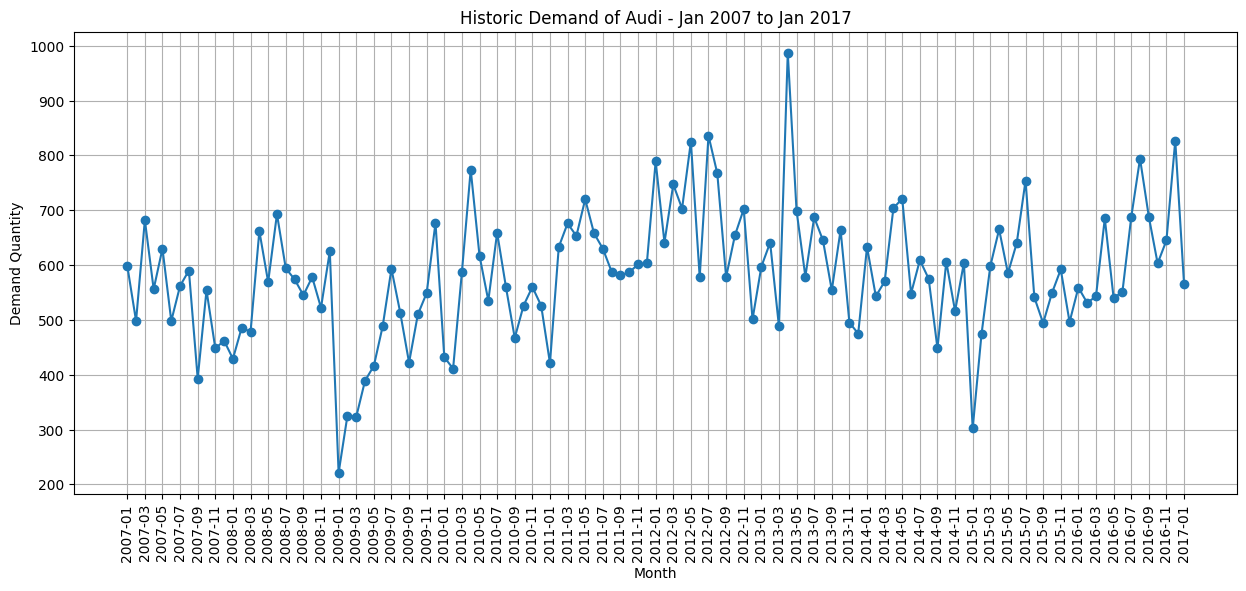

In [ ]:
plot_data(df_audi, title='Historic Demand of Audi - Jan 2007 to Jan 2017')

Except for the few outliers, the demand lies in the 400 to 800 range. There is no obvious trend or seasonality. But we will use the later models to learn the trends and seasonality. Before starting the forecasting process we will define some KPIs that we will track to determine the performance of the models.

In [ ]:
def forecast_KPIs(demand, forecast):

    error = demand - forecast
    avg_demand = np.mean(demand)
    avg_error = np.mean(error)

    Bias = float(avg_error)
    MAD = float(np.mean(np.absolute(demand - avg_demand)))
    MAE = float(np.mean(np.absolute(error)))
    MSE = float(np.mean(np.square(error)))
    RMSE = float(np.sqrt(np.mean(np.square(error))))

    print(f"Bias = {Bias:.2f}, Percentage Bias = {(Bias / avg_demand):.2%}")
    print(f"Mean absolute deviation = {MAD:.2f}, Percentage MAD = {(MAD / avg_demand):.2%}%")
    print(f"Mean absolute error = {MAE:.2f}, Percentage MAE = {(MAE / avg_demand):.2%}")
    print(f"Mean squared error = {MSE:.2f}")
    print(f"Root mean squared error = {RMSE:.2f}")

# 1. Moving Window Average

The demand for time period $t$ is the average of the demands for the last $n$ time periods.

$$ f_t = \frac1n \sum_{i=1}^n d_{(t-i)} $$

$f_t$: Forecast for time period $t$

$d_i$: Demand observed for timer period $t$

$n$: Number of time periods to look back

In [ ]:
def moving_window_average_forecast(demand: np.array, window_length):

    time_periods = len(demand)
    num_of_windows = time_periods - window_length

    X = []
    for i in range(num_of_windows):
        X.append(demand[i:i + window_length])

    X = np.vstack(X)
    Y_obs = demand[window_length:]
    Y_obs = np.ravel(Y_obs)

    Y_forecast = np.mean(X, axis=1)

    df = pd.DataFrame.from_dict({'Demand': Y_obs, 'Forecast': Y_forecast})

    return df

In [ ]:
moving_average_results = moving_window_average_forecast(demand=df_audi.values.ravel(), window_length=12)
forecast_KPIs(moving_average_results['Demand'].values.ravel(), moving_average_results['Forecast'].values.ravel())

Bias = 8.65, Percentage Bias = 1.47%
Mean absolute deviation = 87.37, Percentage MAD = 14.88%%
Mean absolute error = 84.24, Percentage MAE = 14.35%
Mean squared error = 12590.95
Root mean squared error = 112.21


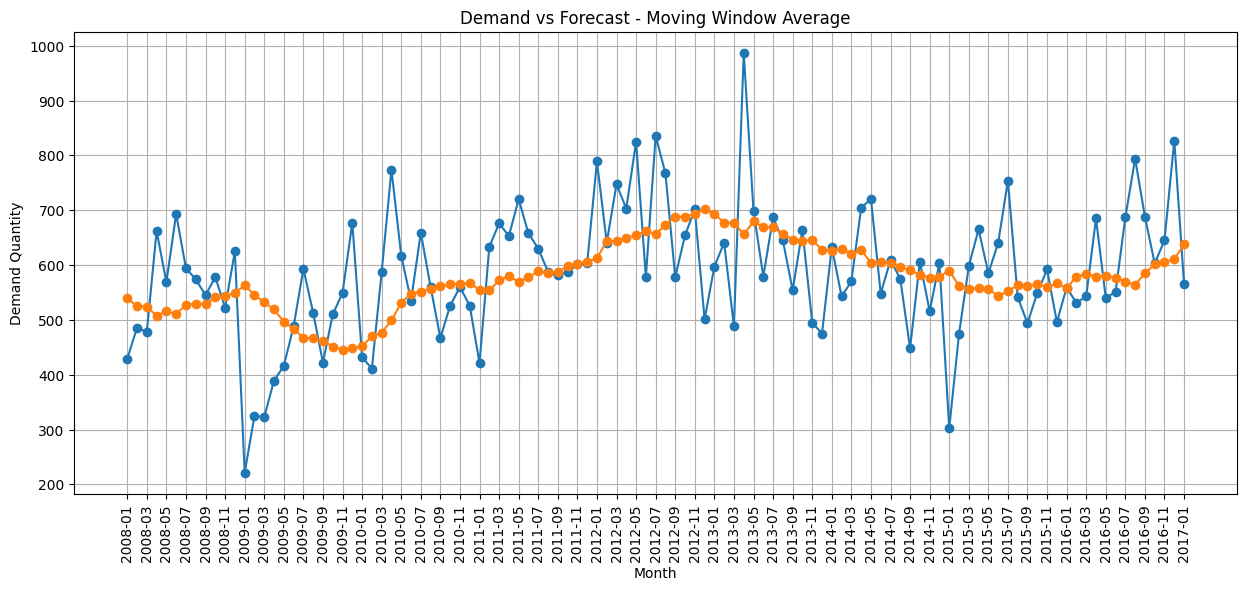

In [ ]:
plot_data(df_audi, results_df=moving_average_results, title="Demand vs Forecast - Moving Window Average")

## Observations

- The forecast done using the moving average window is flat.
- It is unable to take into account the monthly seasonality.
- Any trends in the data are not extrapolated. Look for the period 2009-01 to 2009-07, the actual data shows a continuous upward trend, but the forecasted values do not capture that at all.

# 2. Exponential Smoothing

This model gives certain weights to the last forecast and demand observed. This model learns the level from the demand history.

Definition: Level := The level is the average value around which the demand varies over time. It is the smoothed version of demand history.

$$f_t = α * d_{t-1} + (1 - α) * f_{t-1}$$

$f_t$: Forecast for time period $t$

$d_{t-1}$: Demand observed for time period ${t-1}$

$α$: Weight given to the demand observed, $0 < α \leq 1$

In [ ]:
def simple_exponential_smoothing(demand: np.array, alpha=0.4):

    forecast = np.full(len(demand), np.nan)

    # Initialize first forecast value
    forecast[0] = demand[0]

    for i in range(1, len(demand)):
        forecast[i] = alpha * demand[i-1] + (1 - alpha) * forecast[i-1]

    df = pd.DataFrame.from_dict({'Demand': demand, 'Forecast': forecast})

    return df

In [ ]:
simp_expo_smooth_results = simple_exponential_smoothing(demand=df_audi.values.ravel(), alpha=0.4)
forecast_KPIs(simp_expo_smooth_results['Demand'].values.ravel(), simp_expo_smooth_results['Forecast'].values.ravel())

Bias = 1.23, Percentage Bias = 0.21%
Mean absolute deviation = 85.80, Percentage MAD = 14.73%%
Mean absolute error = 81.26, Percentage MAE = 13.95%
Mean squared error = 11796.79
Root mean squared error = 108.61


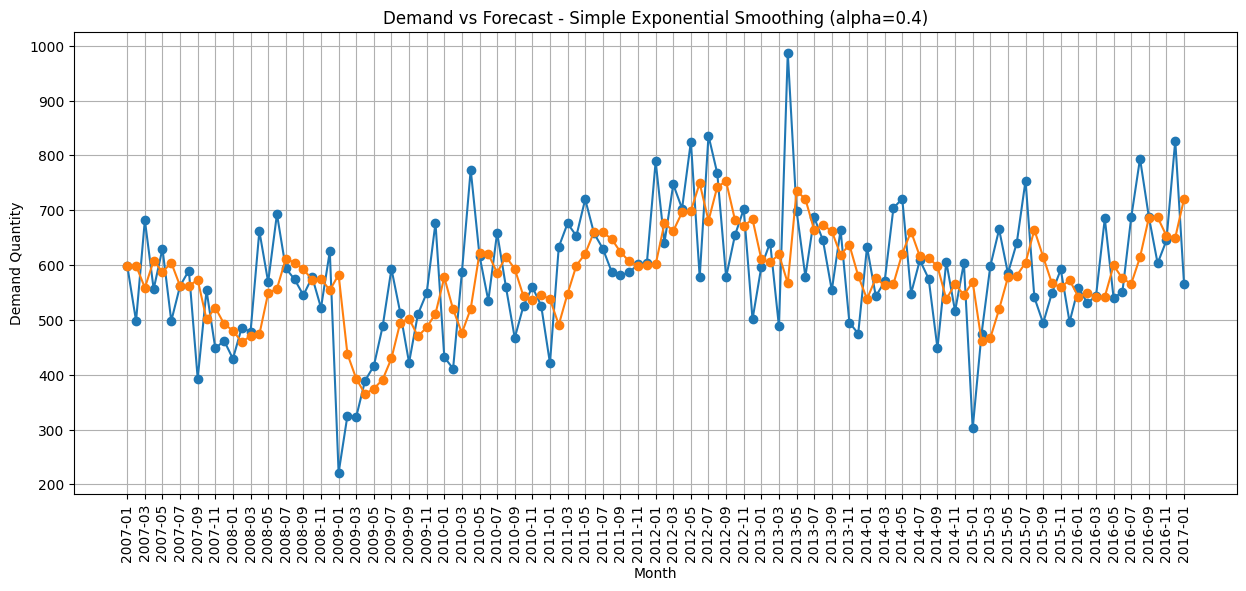

In [ ]:
plot_data(df_audi, results_df=simp_expo_smooth_results, title="Demand vs Forecast - Simple Exponential Smoothing (alpha=0.4)")

## Observations

- This is already much better than the flat forecasts made by moving window average.
- The local trends are captured, look at the same period we observed earliar - between 2009-01 to 2009-07

# 3. Double Exponential Smoothing

This model takes into account the level and the trend observed.

Definition: Trend := The average variation of the time series level between two time periods is defined as the trend.

In this model, the level ($a_t$) as well as the trend ($b_t$) will be learned at every step.

$$a_t = α * d_t + (1 - α) * (a_{t-1} + b_{t-1})$$

$$b_t = β * (a_t - a_{t-1}) + (1 - β) * b_{t-1}$$

$$f_{t+1} = a_{t} + b_{t}$$

$f_{t+1}$: Forecast for time period $t+1$

$a_t$: Level at time period $t$

$b_t$: Trend at time period $t$

$α$: Weight assigned to the demand ($d_t$) observed at time period $t$

$β$: Weight assigned to the difference in level

In [ ]:
def double_exponential_smoothing(demand: np.array, alpha=0.4, beta=0.4):

    forecast = np.full(len(demand), np.nan)
    level = np.full(len(demand), np.nan)
    trend = np.full(len(demand), np.nan)

    # Initialize first forecast, level and trend
    level[0] = demand[0]
    trend[0] = demand[1] - demand[0]
    forecast[0] = demand[0]
    forecast[1] = level[0] + trend[0]

    # Forecast from 3rd time period onwards
    for i in range(2, len(forecast)):
        level[i-1] = alpha * demand[i-1] + (1 - alpha) * (level[i-2] + trend[i-2])
        trend[i-1] = beta * (level[i-1] - level[i-2]) + (1 - beta) * trend[i-2]
        forecast[i] = level[i-1] + trend[i-1]

    df = pd.DataFrame.from_dict({'Demand': demand, 'Forecast': forecast})

    return df

In [ ]:
double_exponential_smoothing_results = double_exponential_smoothing(df_audi.values.ravel(), alpha=0.4, beta=0.4)
forecast_KPIs(double_exponential_smoothing_results['Demand'].values.ravel(), double_exponential_smoothing_results['Forecast'].values.ravel())

Bias = 4.78, Percentage Bias = 0.82%
Mean absolute deviation = 85.80, Percentage MAD = 14.73%%
Mean absolute error = 98.62, Percentage MAE = 16.93%
Mean squared error = 15912.58
Root mean squared error = 126.15


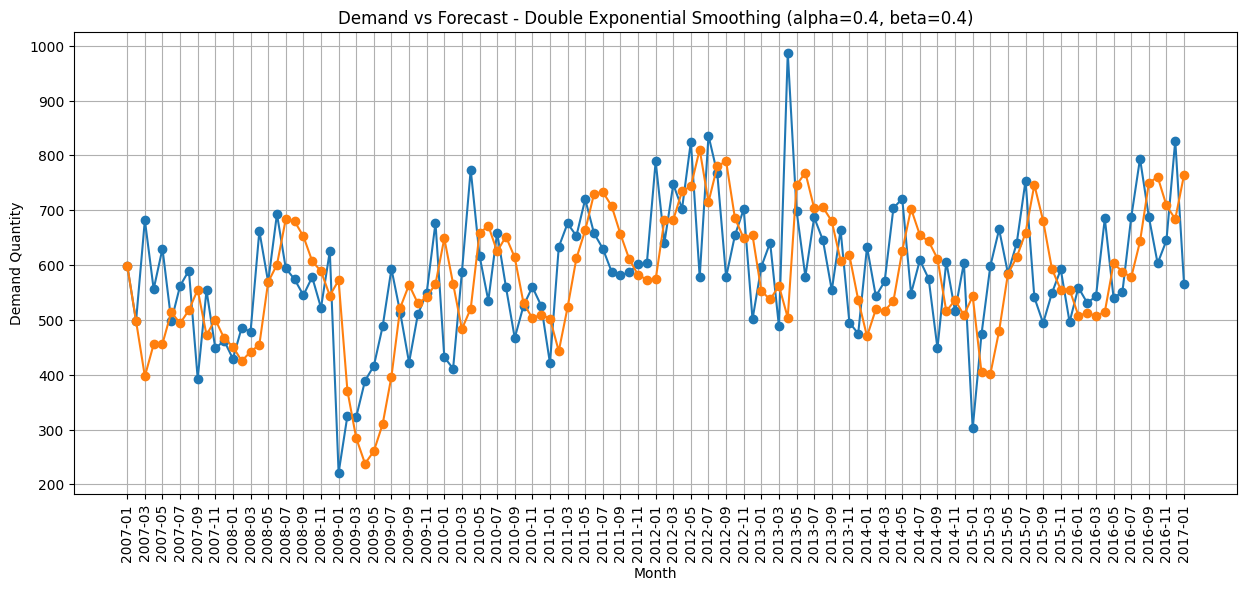

In [ ]:
plot_data(df_audi, results_df=double_exponential_smoothing_results, title="Demand vs Forecast - Double Exponential Smoothing (alpha=0.4, beta=0.4)")

# 4. Double Exponential Smoothing with Damped Trend

$$a_t = α * d_t + (1 - α) * (a_{t-1} + \phi * b_{t-1})$$

$$b_t = β * (a_t - a_{t-1}) + (1 - β) * \phi * b_{t-1}$$

$$f_{t+1} = a_{t} + b_{t} * \phi$$

$f_{t+1}$: Forecast for time period $t+1$

$a_t$: Level at time period $t$

$b_t$: Trend at time period $t$

$α$: Weight assigned to the demand ($d_t$) observed at time period $t$

$β$: Weight assigned to the difference in level

$ϕ$: Damping factor for trend

In [ ]:
def double_exponential_smoothing_with_damped_trend(demand: np.array, alpha=0.4, beta=0.4, phi=0.9):

    forecast = np.full(len(demand), np.nan)
    level = np.full(len(demand), np.nan)
    trend = np.full(len(demand), np.nan)

    # Initialize first forecast, level and trend
    level[0] = demand[0]
    trend[0] = demand[1] - demand[0]
    forecast[0] = demand[0]
    forecast[1] = level[0] + trend[0]

    # Forecast from 3rd time period onwards
    for i in range(2, len(forecast)):
        level[i-1] = alpha * demand[i-1] + (1 - alpha) * (level[i-2] + phi * trend[i-2])
        trend[i-1] = beta * (level[i-1] - level[i-2]) + (1 - beta) * trend[i-2] * phi
        forecast[i] = level[i-1] + phi * trend[i-1]

    df = pd.DataFrame.from_dict({'Demand': demand, 'Forecast': forecast})

    return df

In [ ]:
double_expo_smooth_with_damp_trends_results = double_exponential_smoothing_with_damped_trend(df_audi.values.ravel(), alpha=0.4, beta=0.4, phi=0.9)
forecast_KPIs(double_expo_smooth_with_damp_trends_results['Demand'].values.ravel(), double_expo_smooth_with_damp_trends_results['Forecast'].values.ravel())

Bias = 4.10, Percentage Bias = 0.70%
Mean absolute deviation = 85.80, Percentage MAD = 14.73%%
Mean absolute error = 93.23, Percentage MAE = 16.01%
Mean squared error = 14494.50
Root mean squared error = 120.39


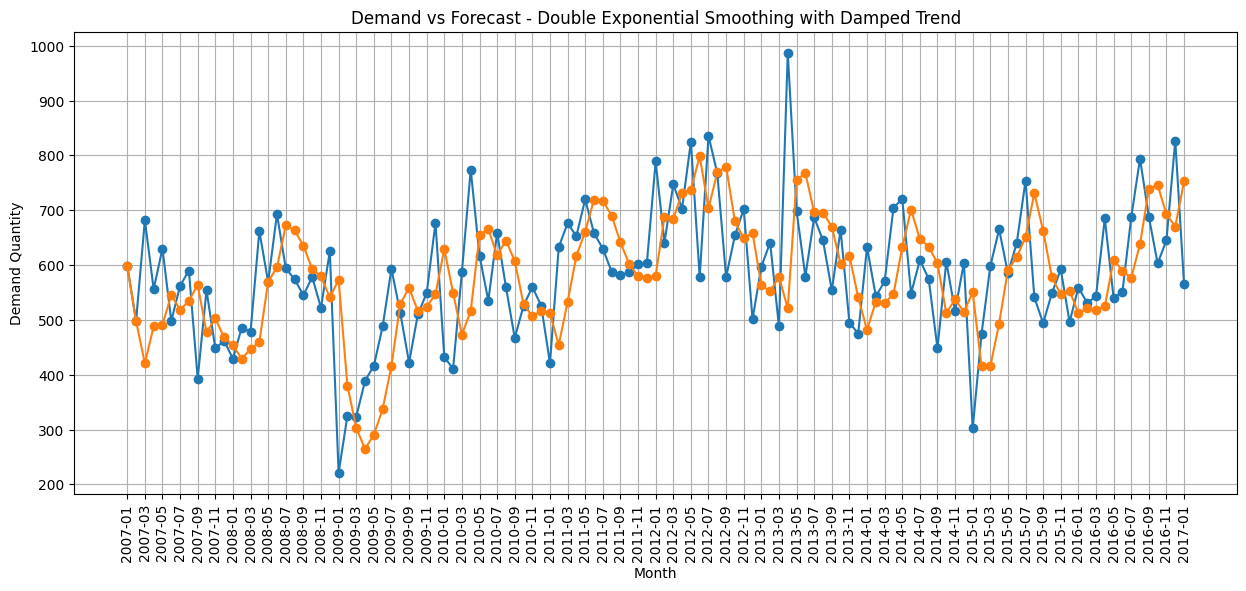

In [ ]:
plot_data(df_audi, results_df=double_expo_smooth_with_damp_trends_results, title="Demand vs Forecast - Double Exponential Smoothing with Damped Trend")

# 5. Triple Exponential Smooting (Multiplicative) with Damped Trend

$$a_t = \frac{α ⋅ d_t}{S_{t-p}} + (1 - α) ⋅ (a_{t-1} + \phi ⋅ b_{t-1})$$

$$b_t = β ⋅ (a_t - a_{t-1}) + (1 - β) ⋅ \phi ⋅ b_{t-1}$$

$$S_t = \frac{γ ⋅ d_t}{a_{t}} + (1 - γ) ⋅ S_{t-p}$$

$$f_{t+1} = (a_{t} + \phi ⋅ b_{t}) ⋅ S_{t+1-p}$$

$f_{t+1}$: Forecast for time period $t+1$

$a_t$: Level at time period $t$

$b_t$: Trend at time period $t$

$S_t$: Seasonality at time period $t$

$p$: Length of season

$α$: Weight assigned to the demand ($d_t$) observed at time period $t$

$β$: Weight assigned to the difference in level

$ϕ$: Damping factor for trend

$γ$: Seasonality learning rate

In [ ]:
def triple_exponential_smoothing_multiplicative_with_damped_trend(demand: np.array, season_length=12, alpha=0.4, beta=0.4, phi=0.9, gamma=0.3):

    forecast = np.full(len(demand), np.nan)
    level = np.full(len(demand), np.nan)
    trend = np.full(len(demand), np.nan)
    season = np.full(len(demand), np.nan)

    avg_monthly_demand = float(np.mean(demand))

    avg_demand_per_month = np.full(season_length, np.nan)

    # Initiate the seasonality rates using the demand rates
    for i in range(season_length):
        avg_demand_per_month[i] = float(np.mean(demand[i::season_length]))
        season[i] = avg_demand_per_month[i] / avg_monthly_demand

    # Initiate the first level, trend
    forecast[0] = demand[0]
    level[0] = demand[0] / season[0]
    trend[0] = demand[1] / season[1] - demand[0] / season[0]

    # Forecast for the first cycle (The seasonality learning rates used here are the ones initiated above)
    for i in range(1, season_length):
        forecast[i] = (level[i-1] + phi * trend[i-1]) * season[i]
        level[i] = alpha * demand[i] / season[i] + (1 - alpha) * (level[i-1] + phi * trend[i-1])
        trend[i] = beta * (level[i] - level[i-1]) + (1 - beta) * phi * trend[i-1]


    # Forecast for the remaining cycle (The seasonality rates will be updated every iteration)
    for i in range(season_length, len(demand)):
        forecast[i] = (level[i-1] + phi * trend[i-1]) * season[i - season_length]
        level[i] = alpha * demand[i] / season[i - season_length] + (1 - alpha) * (level[i-1] + phi * trend[i-1])
        trend[i] = beta * (level[i] - level[i-1]) + (1 - beta) * phi * trend[i-1]
        season[i] = gamma * demand[i] / level[i] + (1 - gamma) * season[i - season_length]

    df = pd.DataFrame.from_dict({'Demand': demand, 'Forecast': forecast})

    return df

In [ ]:
trip_expo_smooth_multi_w_damp_trend_results = triple_exponential_smoothing_multiplicative_with_damped_trend(
                                                    df_audi.values.ravel(),
                                                    season_length=12,
                                                    alpha=0.4,
                                                    beta=0.4,
                                                    phi=0.9,
                                                    gamma=0.3)

forecast_KPIs(trip_expo_smooth_multi_w_damp_trend_results['Demand'].values.ravel(), trip_expo_smooth_multi_w_damp_trend_results['Forecast'].values.ravel())

Bias = 3.71, Percentage Bias = 0.64%
Mean absolute deviation = 85.80, Percentage MAD = 14.73%%
Mean absolute error = 82.26, Percentage MAE = 14.12%
Mean squared error = 12067.21
Root mean squared error = 109.85


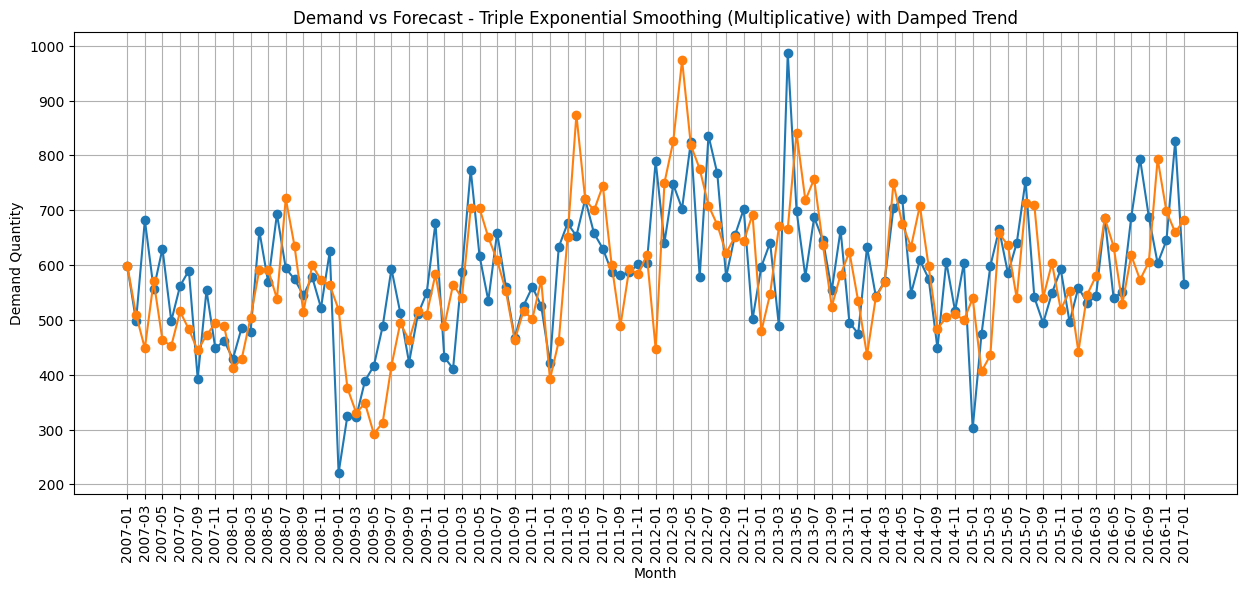

In [ ]:
plot_data(df_audi, results_df=trip_expo_smooth_multi_w_damp_trend_results, title="Demand vs Forecast - Triple Exponential Smoothing (Multiplicative) with Damped Trend")

# 6. Triple Exponential Smoothing (Additive) with Damped Trend

$$a_t = {α ⋅ (d_t - S_{t-p})} + (1 - α) ⋅ (a_{t-1} + \phi ⋅ b_{t-1})$$

$$b_t = β ⋅ (a_t - a_{t-1}) + (1 - β) ⋅ \phi ⋅ b_{t-1}$$

$$S_t = {γ ⋅ (d_t - a_{t})} + (1 - γ) ⋅ S_{t-p}$$

$$f_{t+1} = a_{t} + \phi ⋅ b_{t} + S_{t+1-p}$$

$f_{t+1}$: Forecast for time period $t+1$

$a_t$: Level at time period $t$

$b_t$: Trend at time period $t$

$S_t$: Seasonality at time period $t$

$p$: Length of season

$α$: Weight assigned to the demand ($d_t$) observed at time period $t$

$β$: Weight assigned to the difference in level

$ϕ$: Damping factor for trend

$γ$: Seasonality learning rate

In [ ]:
def triple_exponential_smoothing_with_damped_trend_additive(
    demand: np.array, season_length=12, alpha=0.4, beta=0.4, phi=0.9, gamma=0.3
):
    # Create forecast, level, trend, and season array
    forecast = np.full(len(demand), np.nan)
    level = np.full(len(demand), np.nan)
    trend = np.full(len(demand), np.nan)
    season = np.full(len(demand), np.nan)

    # Calculate average monthly demand
    average_monthly_demand = (demand[:].sum()) / (demand.shape[0])

    # Create average each month demand array
    average_each_month_demand = np.full(season_length, np.nan)

    # Calculate seasonal index for first cycle
    for i in range(0, season_length):
        average_each_month_demand[i] = demand[i : len(demand) : season_length].mean()
        season[i] = average_each_month_demand[i] - average_monthly_demand

    # Forecast initiate
    forecast[0] = demand[0]
    level[0] = demand[0] - season[0]
    trend[0] = (demand[1] - season[1]) - (demand[0] - season[0])

    # Forecast for the first cycle
    for i in range(1, season_length):
        forecast[i] = level[i - 1] + phi * trend[i - 1] + season[i]
        level[i] = alpha * (demand[i] - season[i]) + (1 - alpha) * (level[i - 1] + phi * trend[i - 1])
        trend[i] = beta * (level[i] - level[i - 1]) + (1 - beta) * phi * trend[i - 1]

    # Forecast the rest cycle
    for i in range(season_length, len(demand)):
        forecast[i] = level[i - 1] + phi * trend[i - 1] + season[i - season_length]
        level[i] = alpha * (demand[i] - season[i - season_length]) + (1 - alpha) * (level[i - 1] + phi * trend[i - 1])
        trend[i] = beta * (level[i] - level[i - 1]) + (1 - beta) * phi * trend[i - 1]
        season[i] = gamma * (demand[i] - level[i]) + (1 - gamma) * season[i - season_length]

    # Return the result dataframe
    df = pd.DataFrame.from_dict({"Demand": demand, "Forecast": forecast})
    return df

In [ ]:
trip_expo_smooth_add_w_damp_trend_results = triple_exponential_smoothing_with_damped_trend_additive(
    df_audi.values.ravel(),
    season_length=12,
    alpha=0.4,
    beta=0.4,
    phi=0.9,
    gamma=0.3
)

forecast_KPIs(trip_expo_smooth_add_w_damp_trend_results['Demand'].values.ravel(), trip_expo_smooth_add_w_damp_trend_results['Forecast'].values.ravel())


Bias = 4.82, Percentage Bias = 0.83%
Mean absolute deviation = 85.80, Percentage MAD = 14.73%%
Mean absolute error = 81.22, Percentage MAE = 13.94%
Mean squared error = 11507.26
Root mean squared error = 107.27


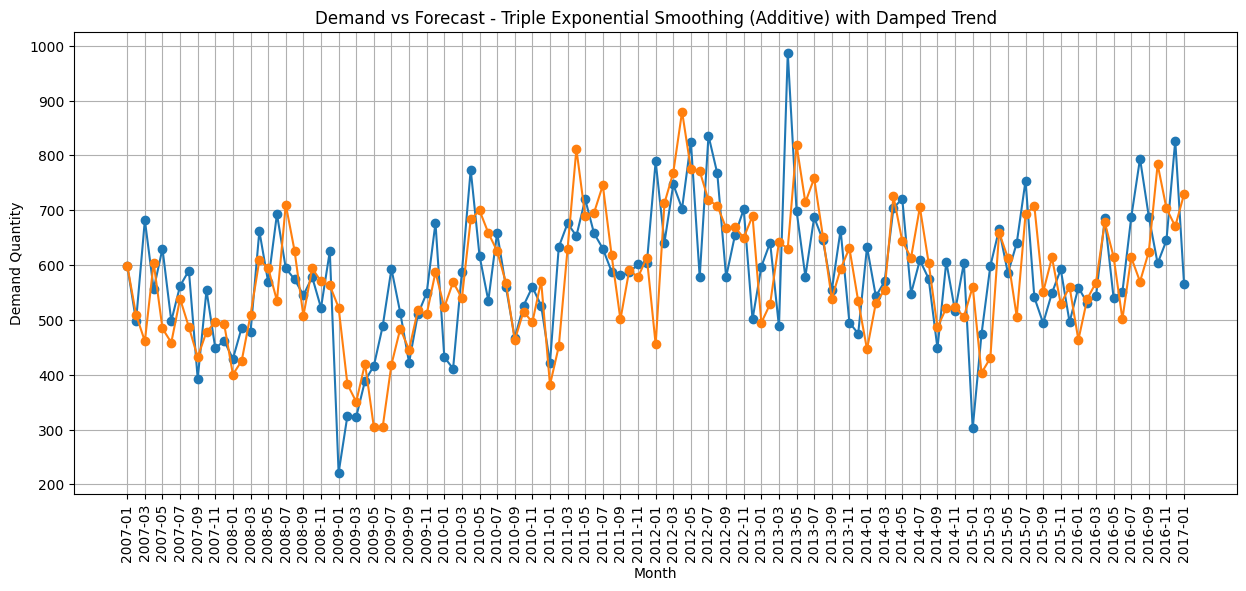

In [ ]:
plot_data(df_audi, results_df=trip_expo_smooth_add_w_damp_trend_results, title="Demand vs Forecast - Triple Exponential Smoothing (Additive) with Damped Trend")

## Comparing the results from all models

In [ ]:
print("Moving Average:")
forecast_KPIs(moving_average_results['Demand'], moving_average_results['Forecast'])
print("------------")
print("Simple Exponential Smoothing")
forecast_KPIs(simp_expo_smooth_results['Demand'], simp_expo_smooth_results['Forecast'])
print("------------")
print("Double Exponential Smoothing")
forecast_KPIs(double_exponential_smoothing_results['Demand'], double_exponential_smoothing_results['Forecast'])
print("------------")
print("Double Exponential Smoothing with Damped Trend")
forecast_KPIs(double_expo_smooth_with_damp_trends_results['Demand'], double_expo_smooth_with_damp_trends_results['Forecast'])
print("------------")
print("Triple Exponential Smoothing (Multiplicative)")
forecast_KPIs(trip_expo_smooth_multi_w_damp_trend_results['Demand'], trip_expo_smooth_multi_w_damp_trend_results['Forecast'])
print("------------")
print("Triple Exponential Smoothing (Additive)")
forecast_KPIs(trip_expo_smooth_add_w_damp_trend_results['Demand'], trip_expo_smooth_add_w_damp_trend_results['Forecast'])

Moving Average:
Bias = 8.65, Percentage Bias = 1.47%
Mean absolute deviation = 87.37, Percentage MAD = 14.88%%
Mean absolute error = 84.24, Percentage MAE = 14.35%
Mean squared error = 12590.95
Root mean squared error = 112.21
------------
Simple Exponential Smoothing
Bias = 1.23, Percentage Bias = 0.21%
Mean absolute deviation = 85.80, Percentage MAD = 14.73%%
Mean absolute error = 81.26, Percentage MAE = 13.95%
Mean squared error = 11796.79
Root mean squared error = 108.61
------------
Double Exponential Smoothing
Bias = 4.78, Percentage Bias = 0.82%
Mean absolute deviation = 85.80, Percentage MAD = 14.73%%
Mean absolute error = 98.62, Percentage MAE = 16.93%
Mean squared error = 15912.58
Root mean squared error = 126.15
------------
Double Exponential Smoothing with Damped Trend
Bias = 4.10, Percentage Bias = 0.70%
Mean absolute deviation = 85.80, Percentage MAD = 14.73%%
Mean absolute error = 93.23, Percentage MAE = 16.01%
Mean squared error = 14494.50
Root mean squared error = 120

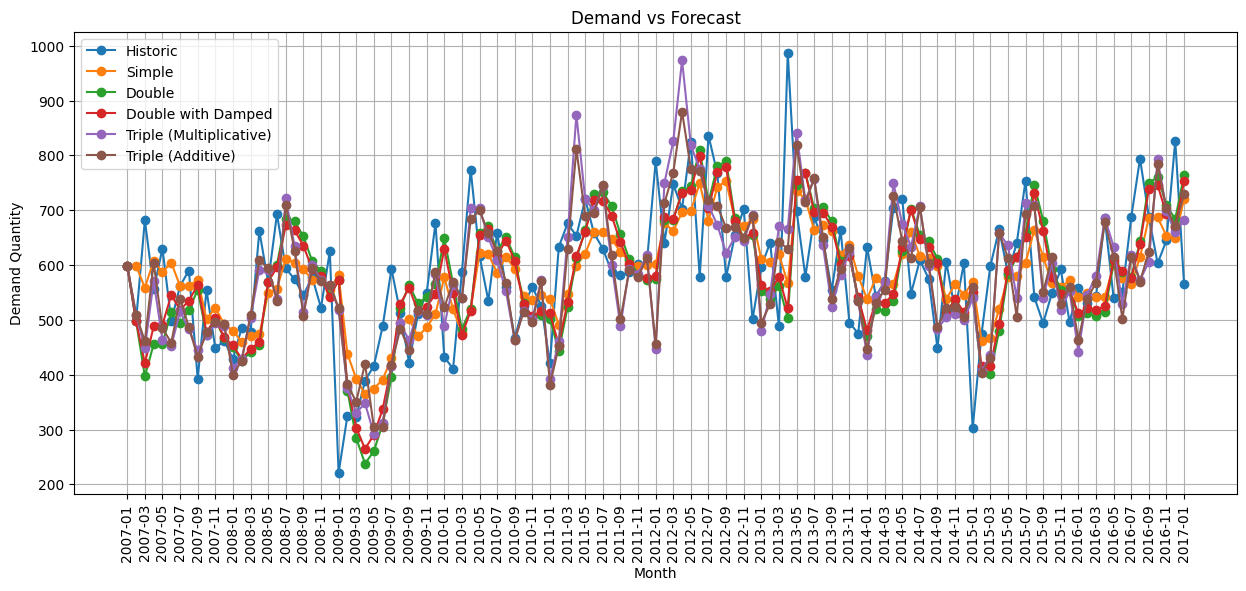

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df.columns.values.ravel()[-(simp_expo_smooth_results.shape[0]):], simp_expo_smooth_results['Demand'].values.ravel(), '-o')
plt.plot(df.columns.values.ravel()[-(simp_expo_smooth_results.shape[0]):], simp_expo_smooth_results['Forecast'].values.ravel(), '-o')
plt.plot(df.columns.values.ravel()[-(simp_expo_smooth_results.shape[0]):], double_exponential_smoothing_results['Forecast'].values.ravel(), '-o')
plt.plot(df.columns.values.ravel()[-(simp_expo_smooth_results.shape[0]):], double_expo_smooth_with_damp_trends_results['Forecast'].values.ravel(), '-o')
plt.plot(df.columns.values.ravel()[-(simp_expo_smooth_results.shape[0]):], trip_expo_smooth_multi_w_damp_trend_results['Forecast'].values.ravel(), '-o')
plt.plot(df.columns.values.ravel()[-(simp_expo_smooth_results.shape[0]):], trip_expo_smooth_add_w_damp_trend_results['Forecast'].values.ravel(), '-o')
plt.title("Demand vs Forecast")
plt.xlabel('Month')
plt.ylabel('Demand Quantity')
plt.xticks(df.columns.values.ravel()[-(simp_expo_smooth_results.shape[0])::2], rotation=90)
plt.legend(['Historic', 'Simple', 'Double', 'Double with Damped', 'Triple (Multiplicative)', 'Triple (Additive)'])
plt.grid('on')
plt.show()

# Optimizing parameters

In [105]:
def exponential_smoothing_optimization(demand):
    params = []  # alphas and betas
    KPIs = []  # result of KPIs
    dfs = []  # result dataframes

    # Loop alpha options
    for alpha in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        df = simple_exponential_smoothing(demand, alpha=alpha)
        params.append(f'Simple Smoothing, alpha: {alpha}')
        dfs.append(df)
        MAE = (df['Demand'] - df['Forecast']).abs().mean()
        KPIs.append(MAE)

        # Loop beta options
        for beta in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            df = double_exponential_smoothing(demand, alpha=alpha, beta=beta)
            params.append(f'Double Smoothing, alpha: {alpha}, beta: {beta}')
            dfs.append(df)
            MAE = (df['Demand'] - df['Forecast']).abs().mean()
            KPIs.append(MAE)

            # Loop phi options
            for phi in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
                df = double_exponential_smoothing_with_damped_trend(demand, alpha=alpha, beta=beta, phi=phi)
                params.append(f'Double Smoothing with Damping, alpha: {alpha}, beta: {beta}, phi: {phi}')
                dfs.append(df)
                MAE = (df['Demand'] - df['Forecast']).abs().mean()
                KPIs.append(MAE)

                # Loop gamma options
                for gamma in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
                    df = triple_exponential_smoothing_multiplicative_with_damped_trend(demand, alpha=alpha, beta=beta, phi=phi, gamma=gamma)
                    params.append(f'Triple Smoothing Multiplicative, alpha: {alpha}, beta: {beta}, phi: {phi}, gamma: {gamma}')
                    dfs.append(df)
                    MAE = (df['Demand'] - df['Forecast']).abs().mean()
                    KPIs.append(MAE)
                    df = triple_exponential_smoothing_with_damped_trend_additive(demand, alpha=alpha, beta=beta, phi=phi, gamma=gamma)
                    params.append(f'Triple Smoothing Additive, alpha: {alpha}, beta: {beta}, phi: {phi}, gamma: {gamma}')
                    dfs.append(df)
                    MAE = (df['Demand'] - df['Forecast']).abs().mean()
                    KPIs.append(MAE)


    # Choosing the dataframe with the best KPI
    mini = np.argmin(KPIs)
    print(f'Best solution found for {params[mini]} MAE of', round(KPIs[mini], 2))

    return dfs[mini]

In [106]:
opti_df = exponential_smoothing_optimization(df_audi.values.ravel())
opti_df

Best solution found for Triple Smoothing Additive, alpha: 0.1, beta: 0.1, phi: 0.6, gamma: 0.05 MAE of 68.0


,Demand,Forecast
0,599,599.000000
1,498,544.010909
2,682,548.623935
3,556,646.350267
4,630,576.646375
...,...,...
116,688,521.392316
117,603,608.868796
118,645,589.476388
119,827,604.651875


In [107]:
opti_results = triple_exponential_smoothing_with_damped_trend_additive(df_audi.values.ravel(), alpha=0.1, beta=0.1, phi=0.6, gamma=0.05)
forecast_KPIs(opti_results['Demand'], opti_results['Forecast'])

Bias = 9.77, Percentage Bias = 1.68%
Mean absolute deviation = 85.80, Percentage MAD = 14.73%%
Mean absolute error = 68.00, Percentage MAE = 11.68%
Mean squared error = 8507.14
Root mean squared error = 92.23


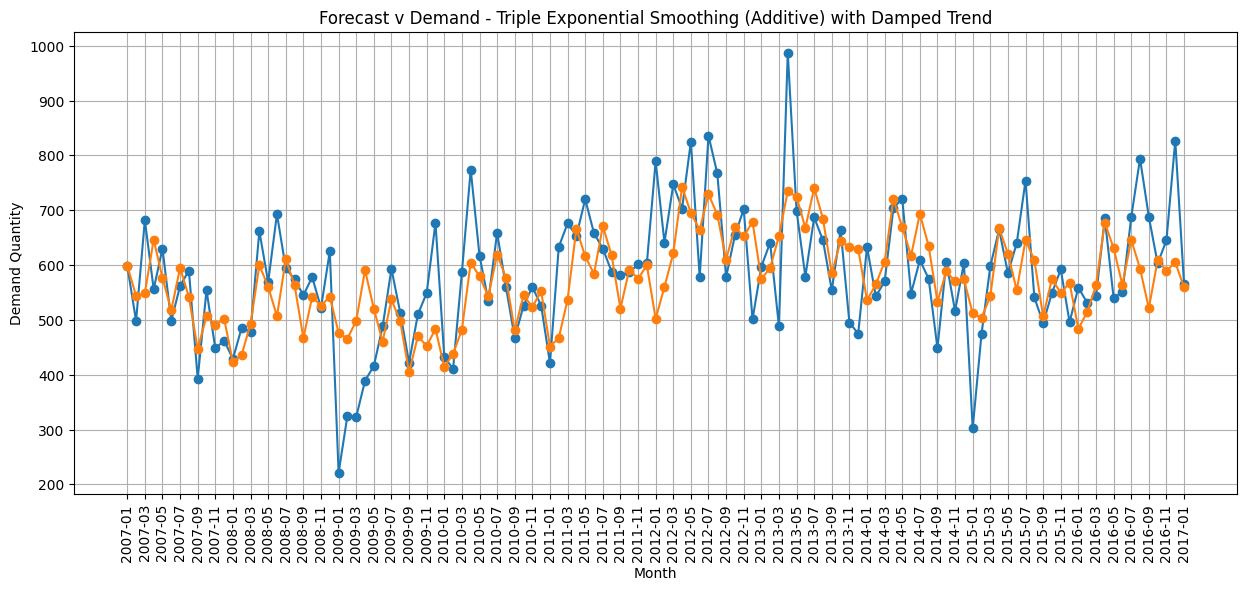

In [108]:
plot_data(df_audi, results_df=opti_results, title="Forecast v Demand - Triple Exponential Smoothing (Additive) with Damped Trend")

# Final Results

- Starting from moving average to triple exponential smoothing, each model tries to learn the more details from the historic demand.
- Depending on the problem, a different KPI can be optimized for while finding the best parameter & model combination.

- To avoid the trap of overfitting, we can leave the last 12 values are test the tuned model.

In [109]:
# Train - test split

X_train = df_audi.values.ravel()[:-13]
X_test = df_audi.values.ravel()[-(13+12):]

In [110]:
train_opti_results = exponential_smoothing_optimization(X_train)

Best solution found for Triple Smoothing Multiplicative, alpha: 0.2, beta: 0.05, phi: 0.6, gamma: 0.05 MAE of 66.61


In [111]:
test_opti_results = triple_exponential_smoothing_multiplicative_with_damped_trend(X_test, season_length=12, alpha=0.2, beta=0.05, phi=0.6, gamma=0.05)
forecast_KPIs(test_opti_results['Demand'], test_opti_results['Forecast'])

Bias = -1.51, Percentage Bias = -0.25%
Mean absolute deviation = 82.12, Percentage MAD = 13.77%%
Mean absolute error = 56.74, Percentage MAE = 9.52%
Mean squared error = 6139.92
Root mean squared error = 78.36


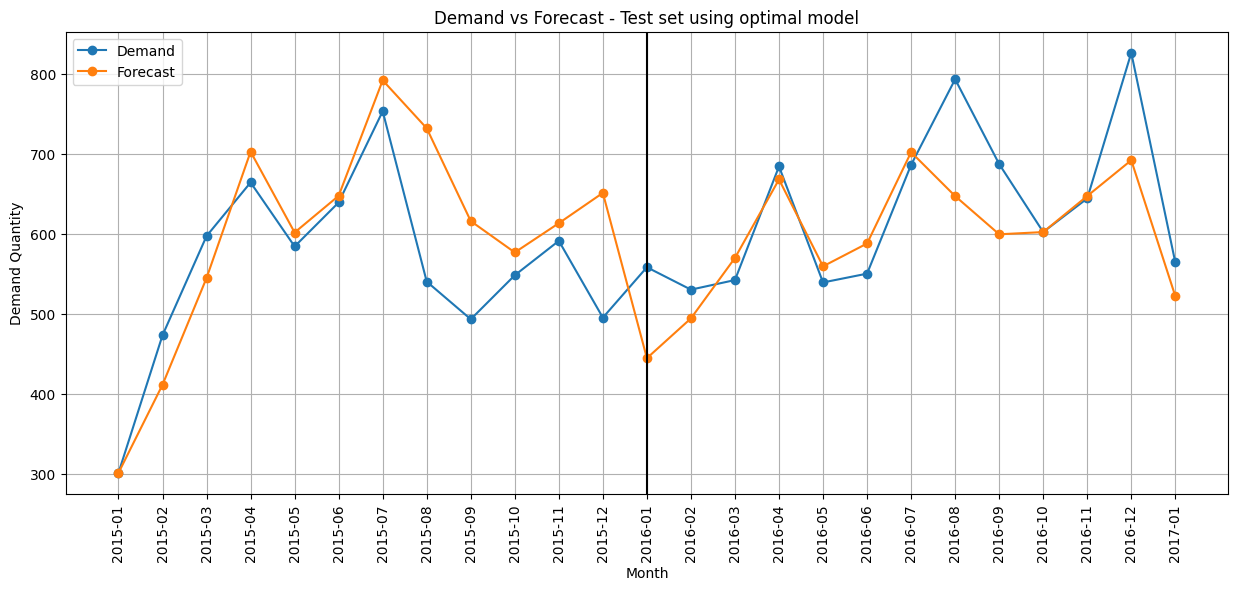

In [112]:
plt.figure(figsize=(15, 6))
plt.plot(df_audi.columns.values.ravel()[-25:], test_opti_results['Demand'], '-o')
plt.plot(df_audi.columns.values.ravel()[-25:], test_opti_results['Forecast'], '-o')
plt.xticks(rotation=90)
plt.title("Demand vs Forecast - Test set using optimal model")
plt.xlabel("Month")
plt.ylabel("Demand Quantity")
plt.legend(['Demand', 'Forecast'])
plt.grid('on')
plt.axvline(x=12, color='k')
plt.show()